## Configuración inicial

A continuación se importan las librerías necesarias para el funcionamiento del notebook. 

In [2]:
#plots and data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#metrics and transformations
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
#Model
from sklearn.ensemble import RandomForestRegressor



sns.set()

In [3]:
#function to measure the performance
def timeseries_evaluation_metrics_func(y_true, y_pred,flag):
    def mean_absolute_percentage_error(y_true, y_pred): 
        epsilon=0.1e-5
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    if flag : print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    else:
        print('Evaluation metric results:')
        print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
        print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
        print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
        print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
        
    return {"MSE":metrics.mean_squared_error(y_true, y_pred),
           "MAE":metrics.mean_absolute_error(y_true, y_pred),
           "RMSE":np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
           "MAPE":mean_absolute_percentage_error(y_true, y_pred)}

In [4]:
def plot_predict_test(df_test_y,testPredict,lag):
        ### Resultado predicción datos de entrenamiento
    fig, ax = plt.subplots(figsize=[15,8])
    sns.lineplot(df_test_y[lag:].flatten(),label="real")
    sns.lineplot(testPredict.flatten(),label="predicción")
    plt.title("Comparación valor real y predicción")
    plt.ylabel("value")

In [5]:
def createLagFeature(name_features,lag,df):
    for name_feature in name_features:
        for i in range(1,lag+1):
            df[name_feature+"lag"+str(i)]=df[name_feature].shift(i)
    return df

---

## Cargar y preparar los datos.

In [3]:
df = pd.read_csv("../../Datasets/Datos_durante_pandemia/data_durante_vol_ve_in.csv")

df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.sort_values('Fecha', ascending=True)
df = df.rename(columns = {'Vol. Futuros': 'VolFuturos'})
df

Fecha  VolFuturos      TRM  Precio Interno        VIX  EMV-ID     EPU
0   2020-01-01    1.289946  3277.14        975000.0  12.548403    1.89  186.06
1   2020-01-02    0.735046  3277.14        945000.0  12.470000    2.84  139.13
2   2020-01-03    0.591834  3258.84        940000.0  14.020000    1.33  108.10
3   2020-01-04    1.367154  3262.05        930000.0  14.646666    0.00  212.82
4   2020-01-05    1.505321  3262.05        920000.0  14.311970    0.86  173.76
..         ...         ...      ...             ...        ...     ...     ...
913 2022-07-02    0.778572  4198.77       2270000.0  25.922916   11.11  130.95
914 2022-07-03    0.819483  4198.77       2270000.0  26.641413   23.06  135.95
915 2022-07-04    0.843804  4198.77       2270000.0  27.530000   15.98  309.83
916 2022-07-05    0.850985  4198.77       2280000.0  27.540000   18.90  116.59
917 2022-07-06    0.840437  4259.86       2302000.0  26.730000    2.27   91.52

[918 rows x 7 columns]

---

## Desarrollo del modelo

In [7]:
#objects to scale the data 
sc=StandardScaler()
sc2=StandardScaler()

In [8]:
df_stats=df

In [9]:
#
len_data=df_stats.shape[0]

#get target
df_label=df_stats["VolFuturos"].values.reshape(len_data,1)
#get attributes
df_data=df_stats.drop(columns=["Fecha"])

#apply scale
#df_label=sc.fit_transform(df_label)
#df_data_normalize=sc2.fit_transform(df_data)


In [10]:
def Model(df_data,df_label,lag,estimators):
    
    df_data_lags=createLagFeature(df_data.columns,lag,df_data) if lag>0 else df_data
    df_data_lags.drop(columns="VolFuturos",inplace=True)
    df_data_lags=df_data_lags[lag:]
    #transform data
    df_data_lags=sc2.fit_transform(df_data_lags)
    
    #split data
    #last index of the train data
    seventy_percent=int(len_data*0.7)

    #split the data normalize
    
    df_train=df_data_lags[:seventy_percent]
    df_test=df_data_lags[seventy_percent:]

    #split labels
    df_label=df_label[lag:]
    df_train_y=df_label[:seventy_percent]
    df_test_y=df_label[seventy_percent:]
    #split labels normalize
    
    df_label_normalize=sc.fit_transform(df_label)
    df_train_y_normalize=df_label_normalize[:seventy_percent]
    df_test_y_normalize=df_label_normalize[seventy_percent:]
    print(df_test_y_normalize.shape)
    print(df_test.shape)


    #make model
    model=RandomForestRegressor(n_estimators=estimators)
    #fit the model with the train data
    history=model.fit(df_train,df_train_y_normalize)
   
    # make predictions
    trainPredict = model.predict(df_train)
    trainPredict = np.reshape(trainPredict,(len(trainPredict),1))
    # invert transformation
    trainPredict = sc.inverse_transform(trainPredict)
    trainY = df_train_y
    
    # make predictions
    testPredict = model.predict(df_test)
    # invert transformation
    testPredict = np.reshape(testPredict,(len(testPredict),1))
    testPredict = sc.inverse_transform(testPredict)
    testY = df_test_y
    print("len test: ",testY.shape)
    print("len PREDICT: ",testPredict.shape)
    
    plot_predict_test(df_train_y,trainPredict,lag)
    plot_predict_test(df_test_y,testPredict,lag)
    return [{"Fecha":df_stats.Fecha[lag:][:seventy_percent],"typeRandomForest":["train"]*len(trainPredict.flatten()),"RandomForest" :trainPredict.flatten()}
            ,{"Fecha":df_stats.Fecha[lag:][seventy_percent:],"typeRandomForest":["test"]*len(testPredict.flatten()),"RandomForest":testPredict.flatten()}]

    return {"train":timeseries_evaluation_metrics_func(trainY.flatten()+1, trainPredict.flatten()+1,False),
           "test":timeseries_evaluation_metrics_func(testY.flatten()+1, testPredict.flatten()+1,False)}

## Resultados

(273, 1)
(273, 23)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.24126293057293324
MAE is : 0.34361744081759354
RMSE is : 0.4911852304100086
MAPE is : 16.474734829266676
Evaluation metric results:
MSE is : 10.778717485596827
MAE is : 3.063067358587012
RMSE is : 3.283095716788779
MAPE is : 176.82531905613007
(273, 1)
(273, 23)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.23105436203222496
MAE is : 0.3414114336766911
RMSE is : 0.48068114382844784
MAPE is : 16.4825983732295
Evaluation metric results:
MSE is : 11.03266261475724
MAE is : 3.1138960245123912
RMSE is : 3.3215452149198934
MAPE is : 179.42719788310606
(273, 1)
(273, 23)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.22692907605128734
MAE is : 0.33962973775653227
RMSE is : 0.47637073383163175
MAPE is : 16.31160055714847
Evaluation metric results:
MSE is : 14.326459119671782
MAE is : 3.5562201332343175
RMSE is : 3.7850309271750717
MAPE is : 202.78367096818909
(273, 1)
(273, 23)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.22874487953197672
MAE is : 0.33927747767928096
RMSE is : 0.47827280868974426
MAPE is : 16.363726484491067
Evaluation metric results:
MSE is : 12.687943059176895
MAE is : 3.3335343214419377
RMSE is : 3.562013904966809
MAPE is : 191.34672386214288
(273, 1)
(273, 23)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.21800999465955054
MAE is : 0.33592223286889916
RMSE is : 0.46691540417890537
MAPE is : 16.213259775006726
Evaluation metric results:
MSE is : 13.012062989342708
MAE is : 3.3838647025663224
RMSE is : 3.6072237232174422
MAPE is : 193.67824969557108
(271, 1)
(271, 35)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.23580939919175972
MAE is : 0.33676432395543704
RMSE is : 0.4856020996574868
MAPE is : 16.289091087031217
Evaluation metric results:
MSE is : 14.486368207377554
MAE is : 3.5835743243725005
RMSE is : 3.806096189979643
MAPE is : 204.59429249120154
(271, 1)
(271, 35)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.2122022281923041
MAE is : 0.3392270480520735
RMSE is : 0.4606541307665699
MAPE is : 16.662646079581574
Evaluation metric results:
MSE is : 18.380201275936304
MAE is : 4.040609919837972
RMSE is : 4.287213696089373
MAPE is : 229.00388618890582
(271, 1)
(271, 35)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.2202980493857606
MAE is : 0.33408280838361887
RMSE is : 0.46935919015798616
MAPE is : 16.17948400663268
Evaluation metric results:
MSE is : 16.648753693686192
MAE is : 3.842659859619889
RMSE is : 4.08028843265843
MAPE is : 218.06178662173767
(271, 1)
(271, 35)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.21798626635993423
MAE is : 0.335102806322701
RMSE is : 0.46688999385287133
MAPE is : 16.333735485106608
Evaluation metric results:
MSE is : 16.765453279825536
MAE is : 3.855601692191205
RMSE is : 4.0945638693059285
MAPE is : 219.30576170997807
(271, 1)
(271, 35)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.21727092529214553
MAE is : 0.3333231321349836
RMSE is : 0.4661232940887481
MAPE is : 16.18475425301623
Evaluation metric results:
MSE is : 16.573369284406738
MAE is : 3.8421311832115714
RMSE is : 4.071040319673429
MAPE is : 218.1775573252871
(269, 1)
(269, 47)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.24272311769519697
MAE is : 0.34759655947112217
RMSE is : 0.49266937970123226
MAPE is : 16.736345274319497
Evaluation metric results:
MSE is : 16.44343714444041
MAE is : 3.819992512536656
RMSE is : 4.055050818971374
MAPE is : 217.42133632168407


<ipython-input-4-f7487097fa4e>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=[15,8])


(269, 1)
(269, 47)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.2371001059609967
MAE is : 0.3464446933418485
RMSE is : 0.48692926176293483
MAPE is : 16.79441028819809
Evaluation metric results:
MSE is : 17.94723388080902
MAE is : 4.016096058590851
RMSE is : 4.236417576303004
MAPE is : 227.58721643210546
(269, 1)
(269, 47)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.2324512257614564
MAE is : 0.34498725392711077
RMSE is : 0.48213195886754534
MAPE is : 16.804514501141785
Evaluation metric results:
MSE is : 14.71076650473461
MAE is : 3.6170561500719325
RMSE is : 3.835461706852854
MAPE is : 206.64165049345385
(269, 1)
(269, 47)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.21204902201093584
MAE is : 0.3341899270374782
RMSE is : 0.4604878087538647
MAPE is : 16.27876150185859
Evaluation metric results:
MSE is : 17.28146608898091
MAE is : 3.9201148949117686
RMSE is : 4.157098277522545
MAPE is : 222.30969890116577
(269, 1)
(269, 47)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.21791045094294156
MAE is : 0.3381938362696827
RMSE is : 0.4668087948431794
MAPE is : 16.454999205396874
Evaluation metric results:
MSE is : 17.411692478083364
MAE is : 3.942301335447749
RMSE is : 4.172732016087705
MAPE is : 223.61266060020304
(268, 1)
(268, 53)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.21579937108715047
MAE is : 0.33747744821234177
RMSE is : 0.4645421090570267
MAPE is : 16.489800825869196
Evaluation metric results:
MSE is : 13.3936439111277
MAE is : 3.428873321571112
RMSE is : 3.659732764988135
MAPE is : 196.87411584772568
(268, 1)
(268, 53)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.22103655313176163
MAE is : 0.3379498926969348
RMSE is : 0.47014524684586745
MAPE is : 16.624548174503207
Evaluation metric results:
MSE is : 13.040690245549662
MAE is : 3.3845242051171245
RMSE is : 3.611189588701992
MAPE is : 194.45847321752768
(268, 1)
(268, 53)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.21650422586260365
MAE is : 0.33719810287081126
RMSE is : 0.4653001459946081
MAPE is : 16.421260731480764
Evaluation metric results:
MSE is : 12.31853412909772
MAE is : 3.296307304884818
RMSE is : 3.5097769343788388
MAPE is : 189.84821040693075
(268, 1)
(268, 53)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.22450227430827352
MAE is : 0.3417961708732486
RMSE is : 0.4738167096127716
MAPE is : 16.6122033897843
Evaluation metric results:
MSE is : 10.528489257773023
MAE is : 3.0357629404567756
RMSE is : 3.244763359287241
MAPE is : 176.16432660283357
(268, 1)
(268, 53)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.21954535275828266
MAE is : 0.33475762655884833
RMSE is : 0.468556669740473
MAPE is : 16.33303226181615
Evaluation metric results:
MSE is : 9.136638985424732
MAE is : 2.8119580271588127
RMSE is : 3.022687378050322
MAPE is : 164.19759471721306
(266, 1)
(266, 65)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.21798224414996703
MAE is : 0.3418218847771806
RMSE is : 0.46688568638368755
MAPE is : 16.696678783184748
Evaluation metric results:
MSE is : 9.066477326754322
MAE is : 2.794616760409349
RMSE is : 3.0110591702512792
MAPE is : 163.78089479810785
(266, 1)
(266, 65)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.21821968077022738
MAE is : 0.3345660851558224
RMSE is : 0.46713989421823887
MAPE is : 16.163691565649984
Evaluation metric results:
MSE is : 10.685056916975022
MAE is : 3.0659439504871333
RMSE is : 3.268800531842685
MAPE is : 177.97768968853796
(266, 1)
(266, 65)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.21865933923776154
MAE is : 0.333851925752286
RMSE is : 0.46761024287087805
MAPE is : 16.343358186436177
Evaluation metric results:
MSE is : 10.640537488345531
MAE is : 3.0624525661196627
RMSE is : 3.2619836738318497
MAPE is : 177.73288093359295
(266, 1)
(266, 65)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.21098765260624333
MAE is : 0.3303028547706688
RMSE is : 0.4593339227688756
MAPE is : 16.14794575727225
Evaluation metric results:
MSE is : 8.843553144753951
MAE is : 2.77234315485201
RMSE is : 2.9738112153857297
MAPE is : 162.54084617056066
(266, 1)
(266, 65)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.21725920292670975
MAE is : 0.33401845288282206
RMSE is : 0.46611071960072936
MAPE is : 16.266004174691464
Evaluation metric results:
MSE is : 9.523557583913643
MAE is : 2.8822493731379075
RMSE is : 3.0860261800434623
MAPE is : 168.47986605703576
(261, 1)
(261, 95)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.23645943118899806
MAE is : 0.34541439295202914
RMSE is : 0.48627094421628575
MAPE is : 16.939946941981653
Evaluation metric results:
MSE is : 5.887476820485494
MAE is : 2.215089049668382
RMSE is : 2.4264123352154088
MAPE is : 131.07604235055385
(261, 1)
(261, 95)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.21948221599669882
MAE is : 0.3325373709975636
RMSE is : 0.4684892912294782
MAPE is : 16.386342184772634
Evaluation metric results:
MSE is : 6.947760159736291
MAE is : 2.417801631137261
RMSE is : 2.63586042114075
MAPE is : 142.4408335977893
(261, 1)
(261, 95)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.21367846573319144
MAE is : 0.3328728833855639
RMSE is : 0.462253681146177
MAPE is : 16.186831731014312
Evaluation metric results:
MSE is : 7.154227427711454
MAE is : 2.4561906303571037
RMSE is : 2.6747387587784073
MAPE is : 144.99527977046648
(261, 1)
(261, 95)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.2179160970901168
MAE is : 0.3335898212380091
RMSE is : 0.4668148424055482
MAPE is : 16.298897070329577
Evaluation metric results:
MSE is : 8.280539137425055
MAE is : 2.6590026049455617
RMSE is : 2.8775925940662717
MAPE is : 155.6607218357542
(261, 1)
(261, 95)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.21345446857249395
MAE is : 0.33260269378139473
RMSE is : 0.46201132948499646
MAPE is : 16.299612840725548
Evaluation metric results:
MSE is : 7.1284060729500665
MAE is : 2.4562443987391256
RMSE is : 2.6699075026955645
MAPE is : 144.45366197652044


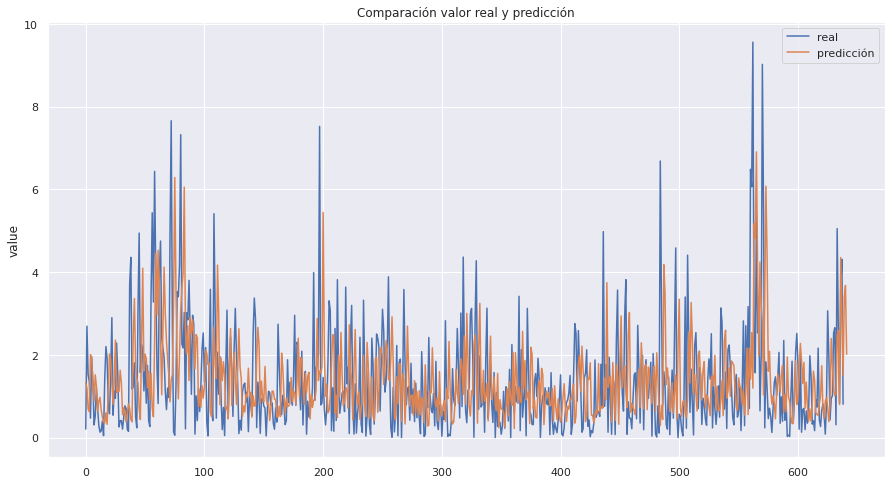

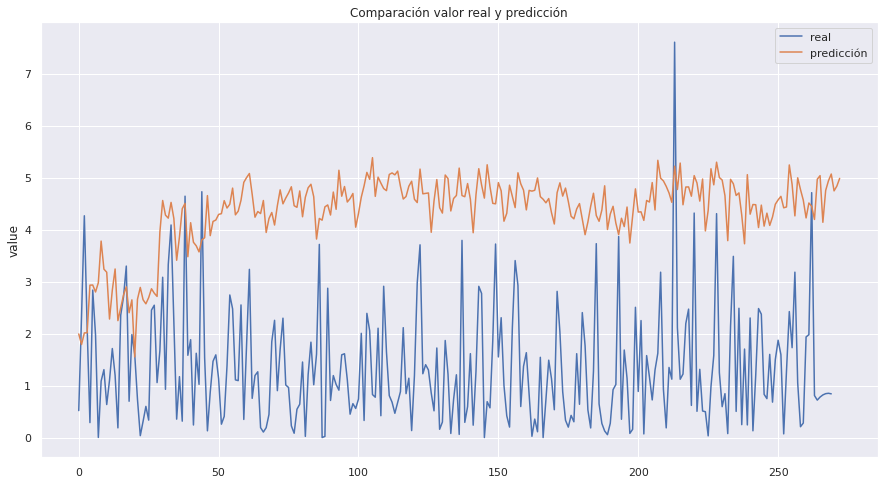

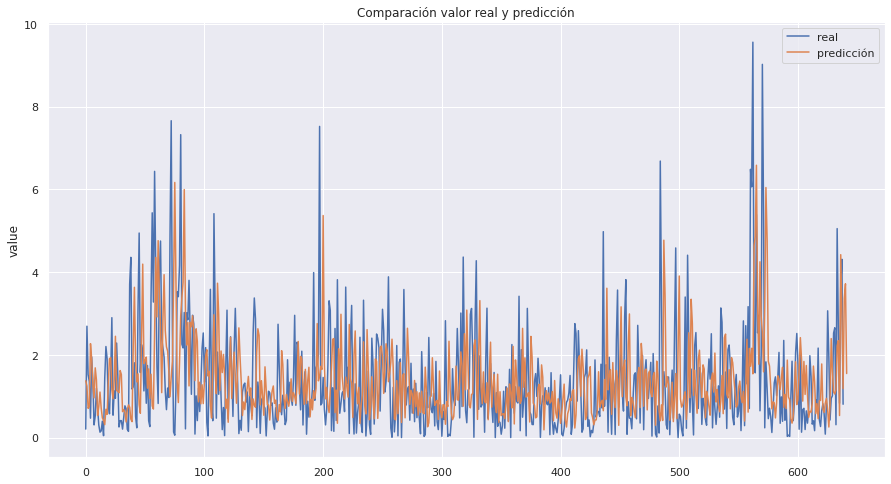

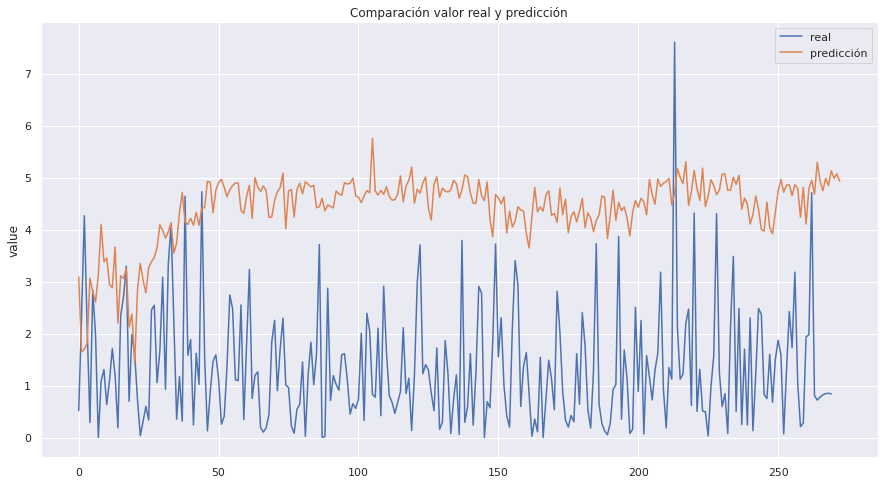

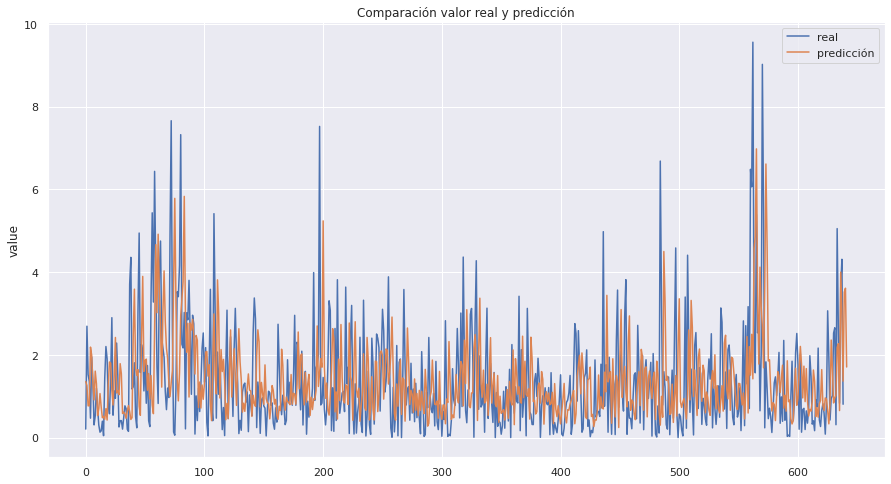

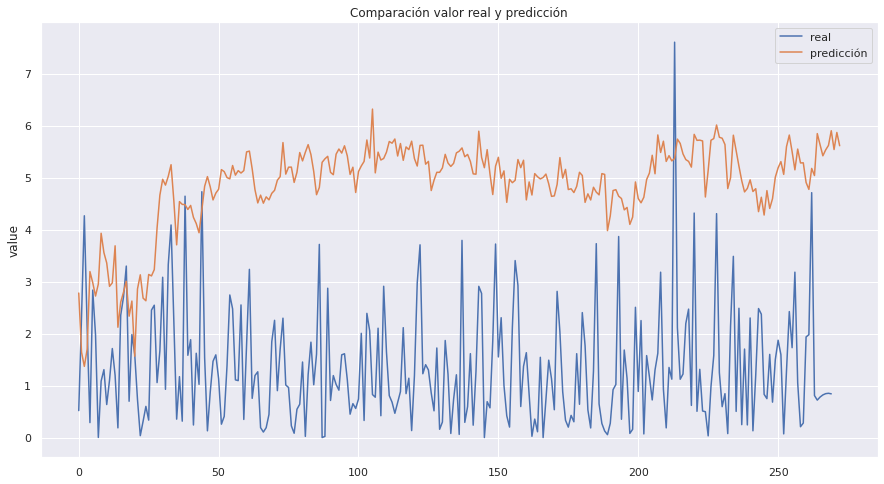

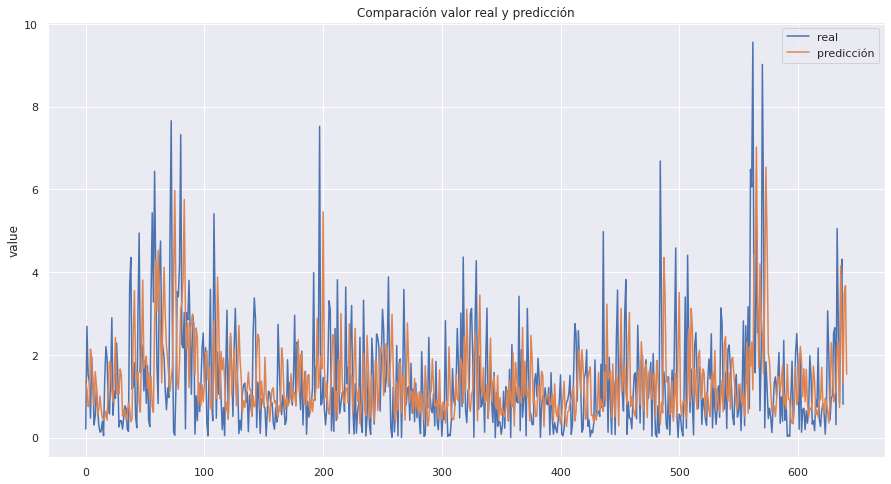

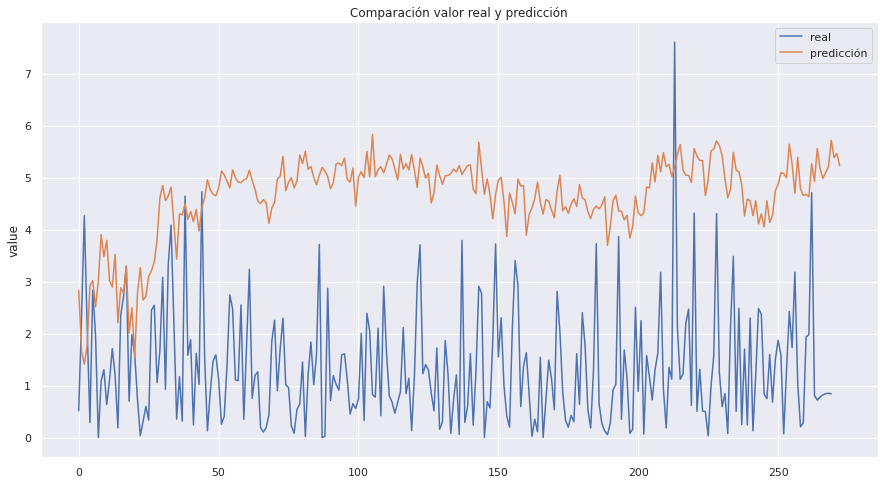

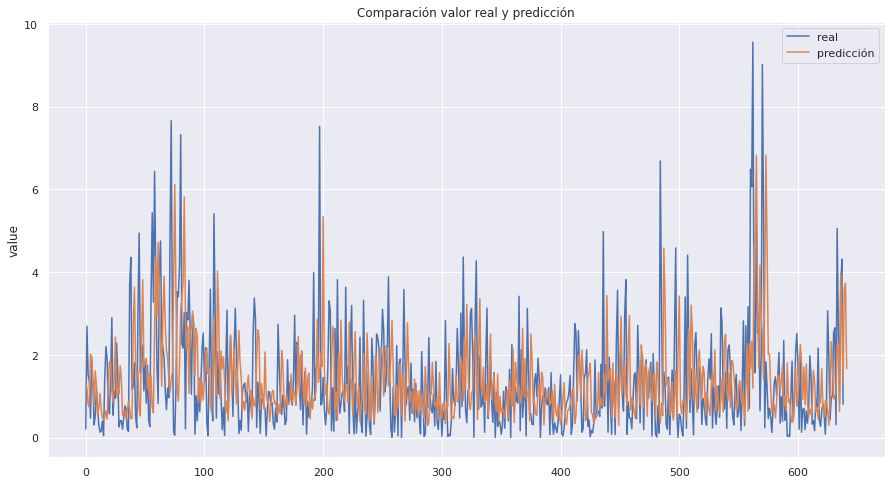

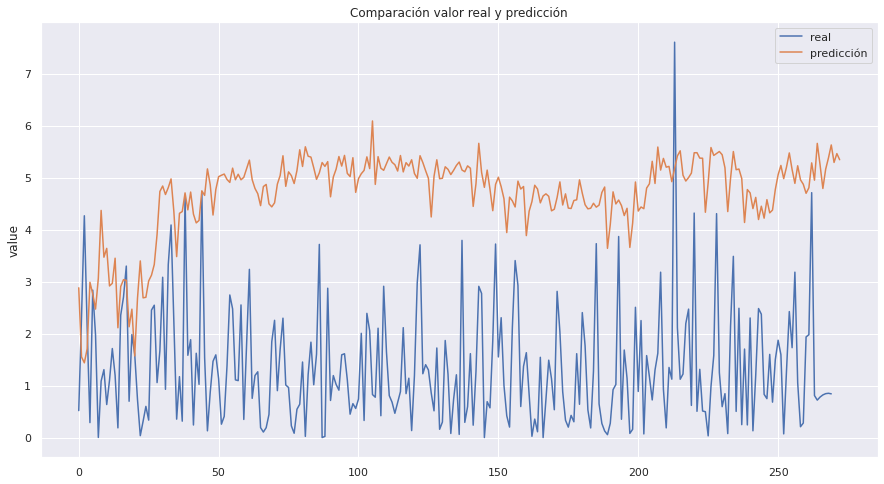

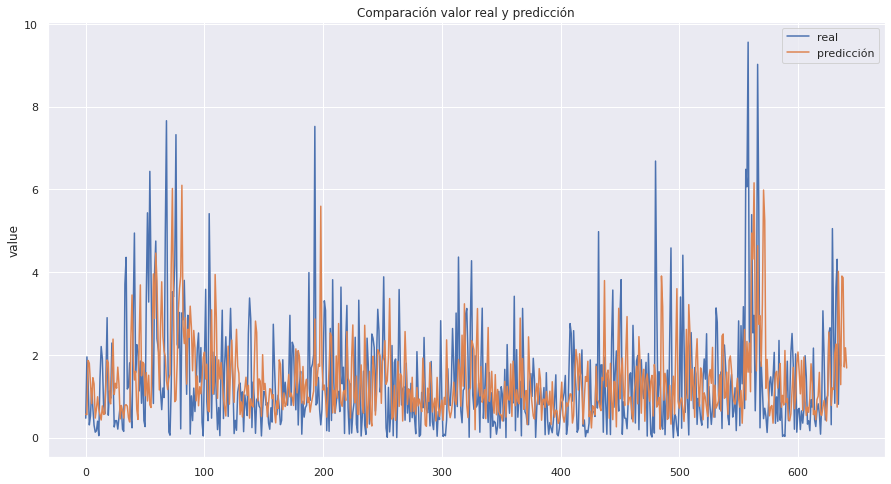

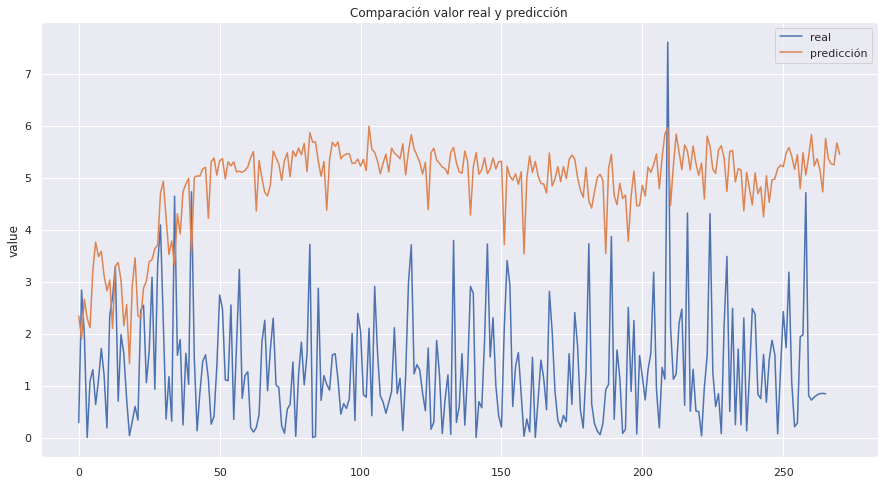

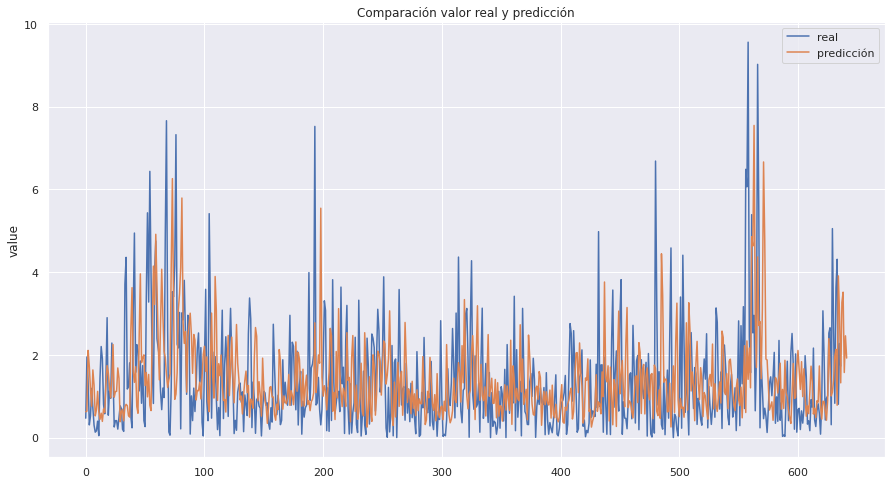

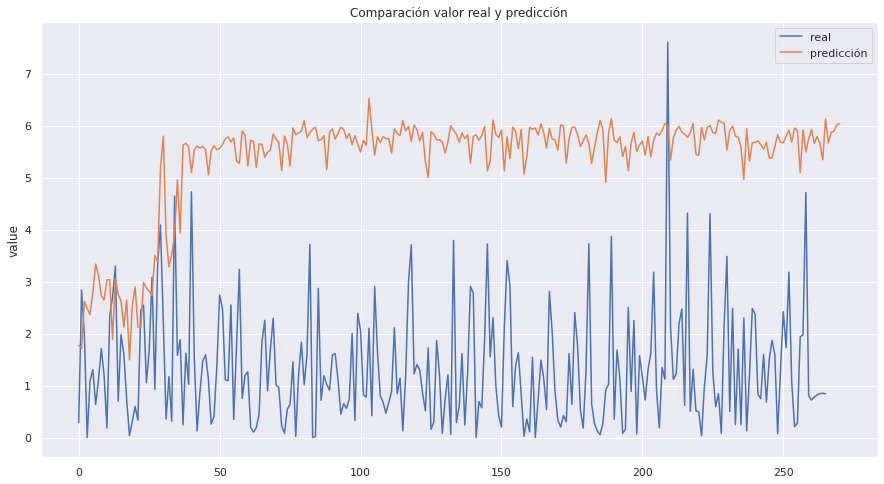

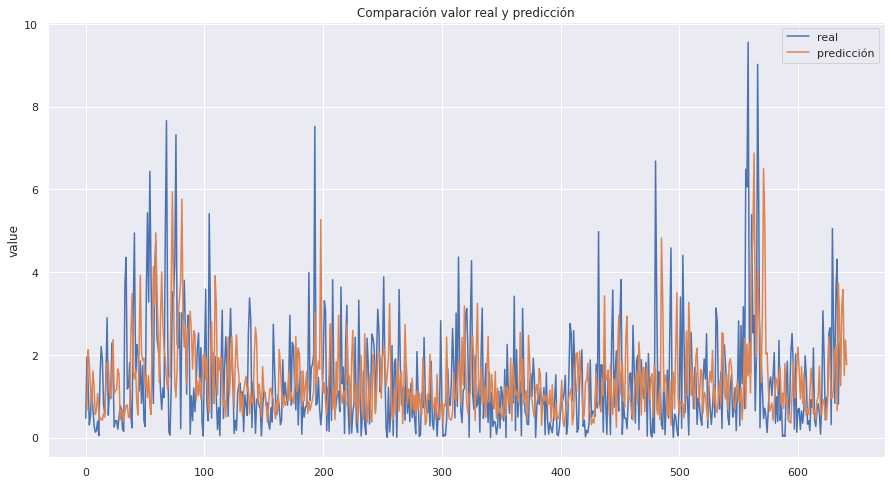

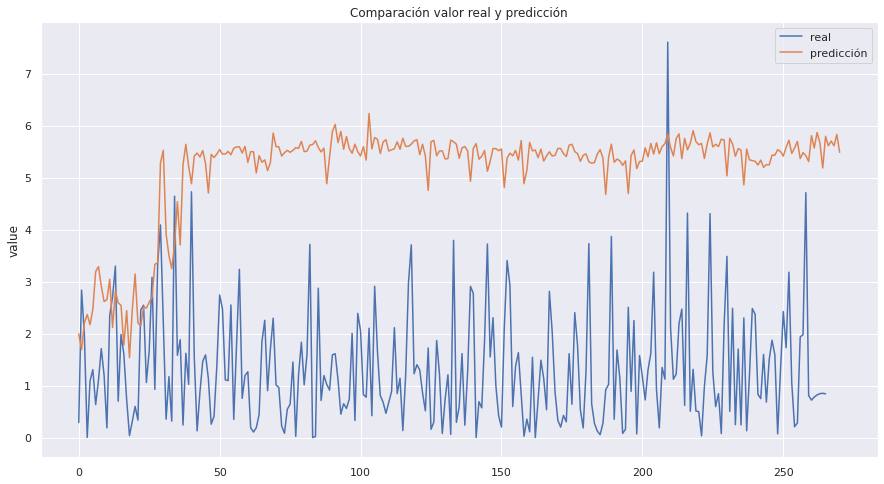

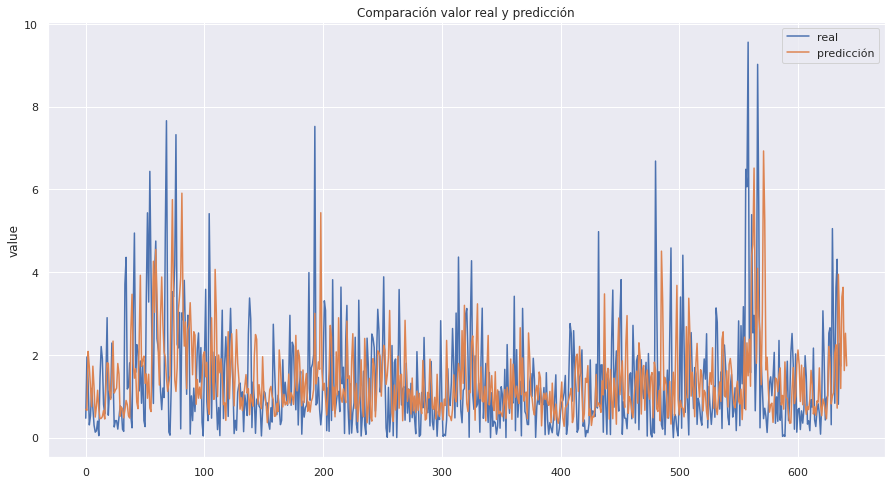

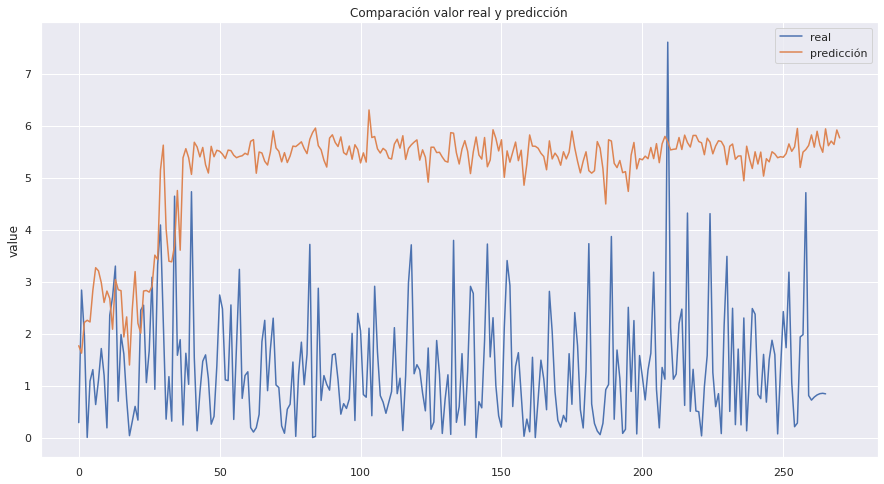

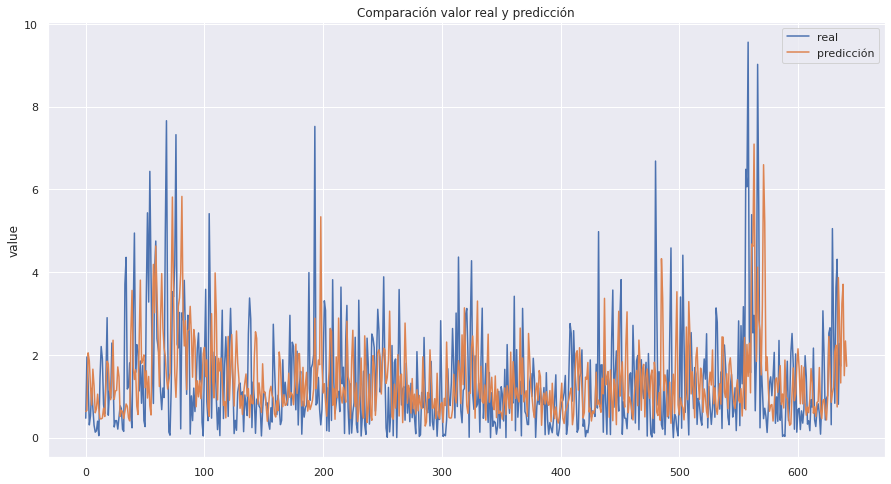

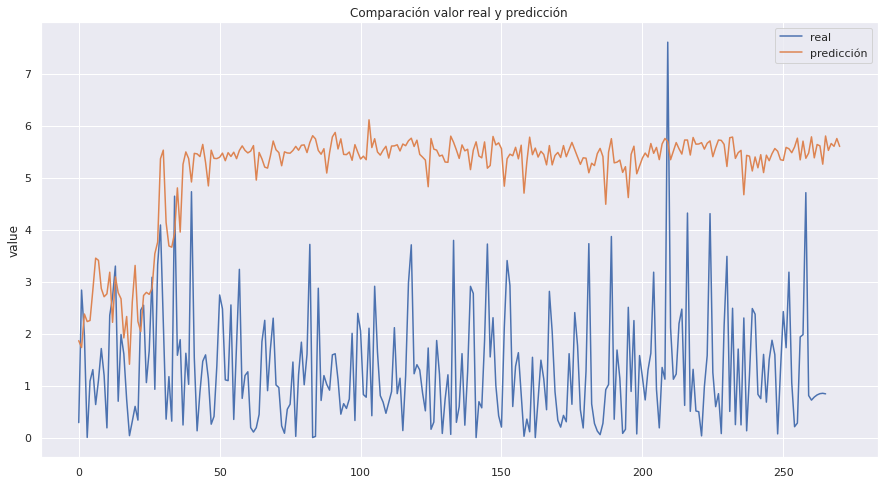

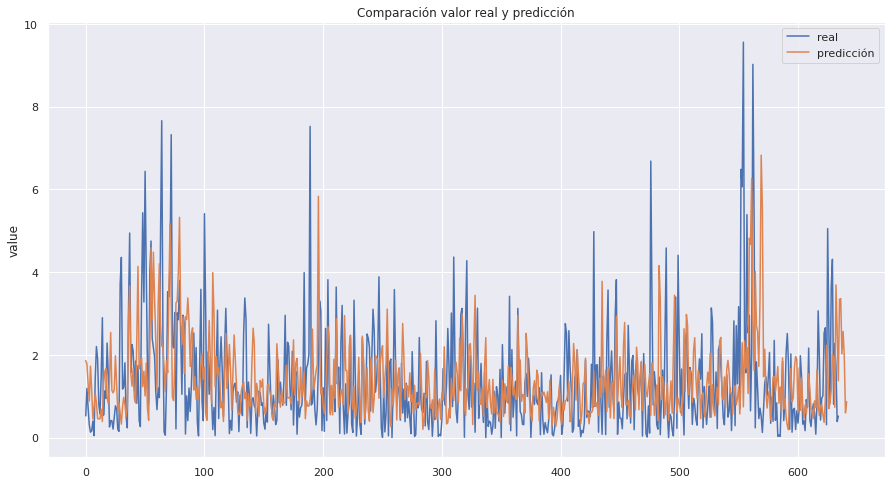

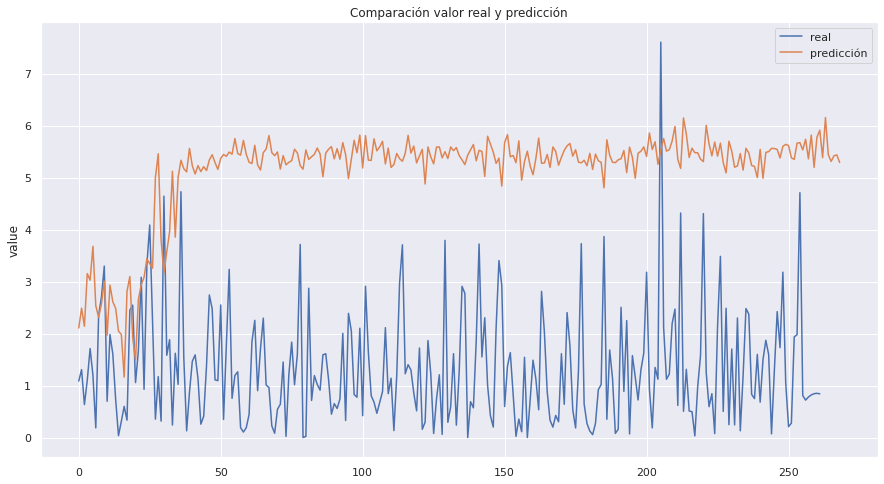

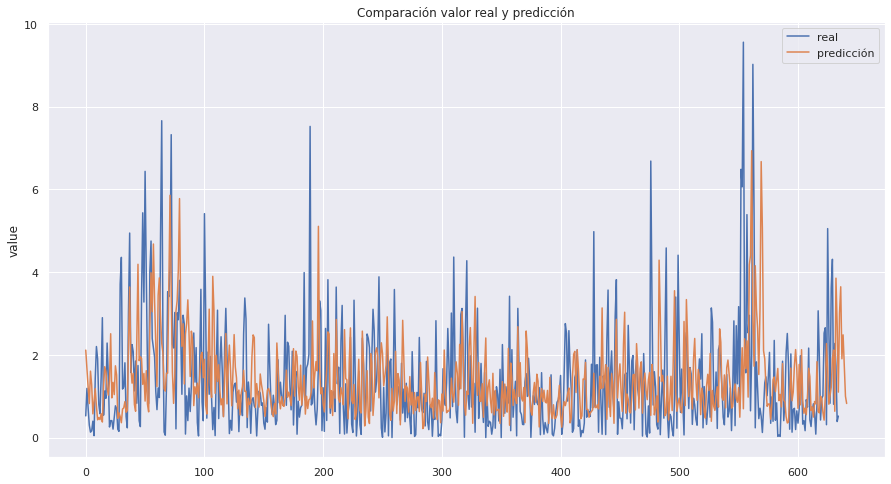

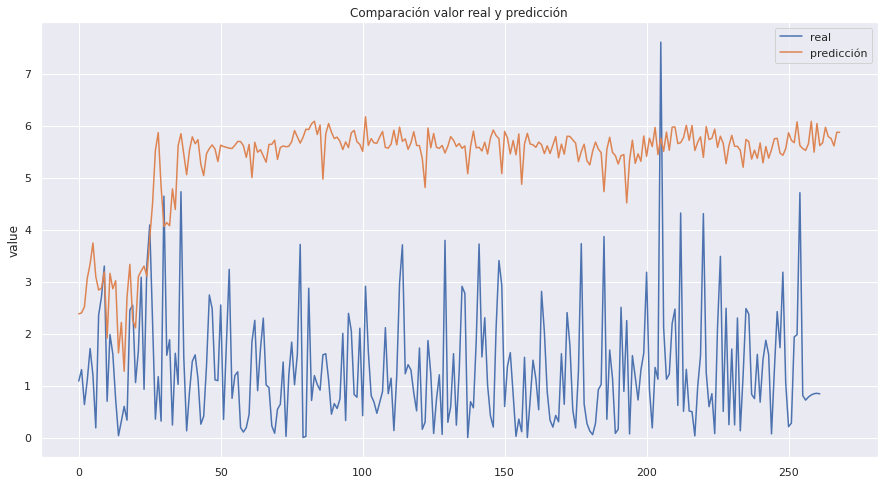

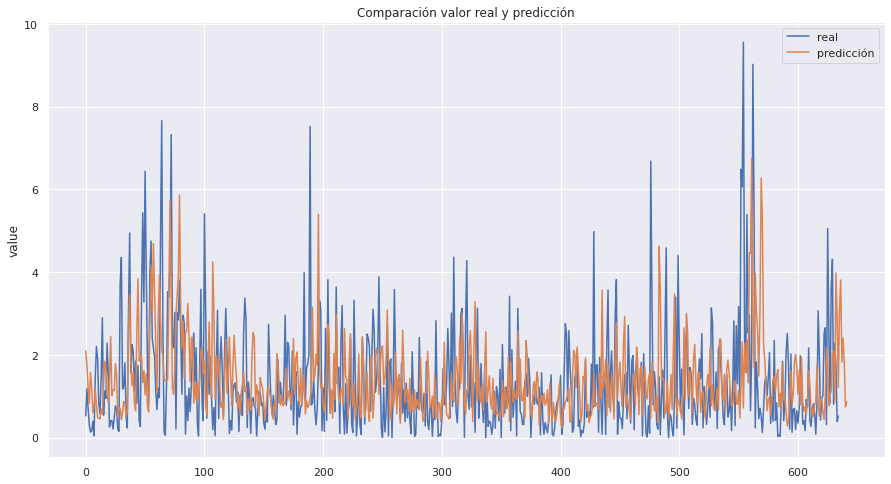

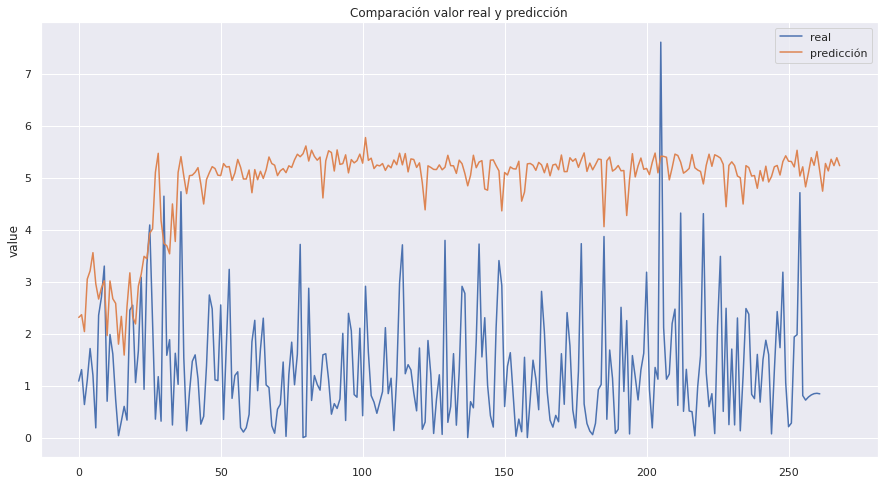

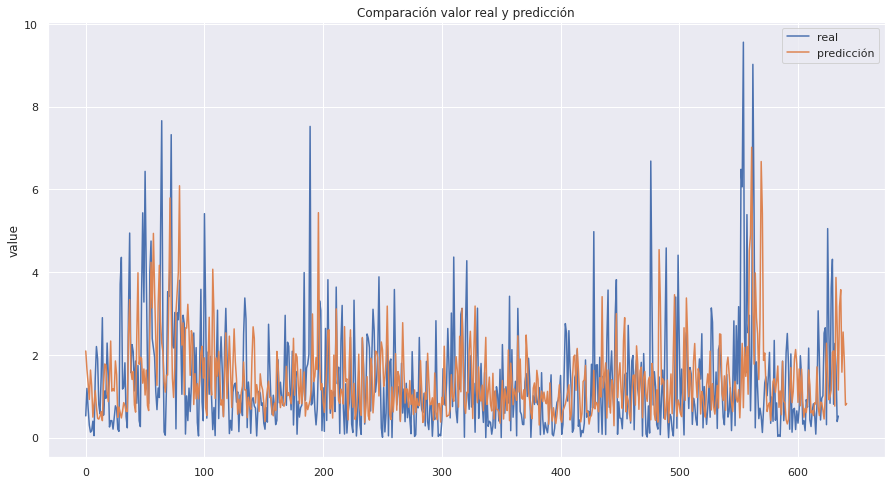

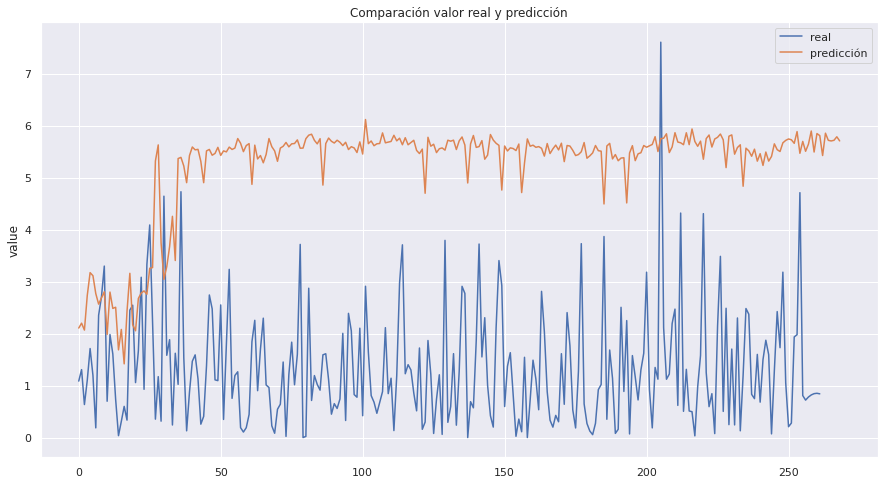

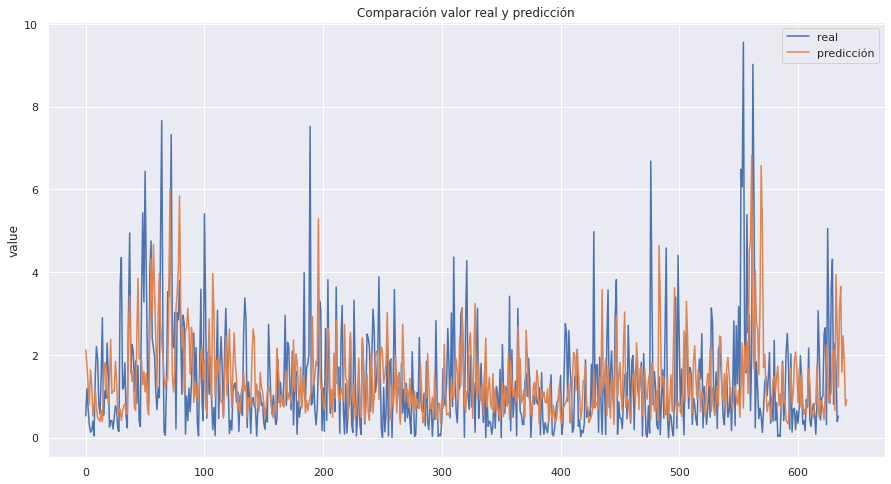

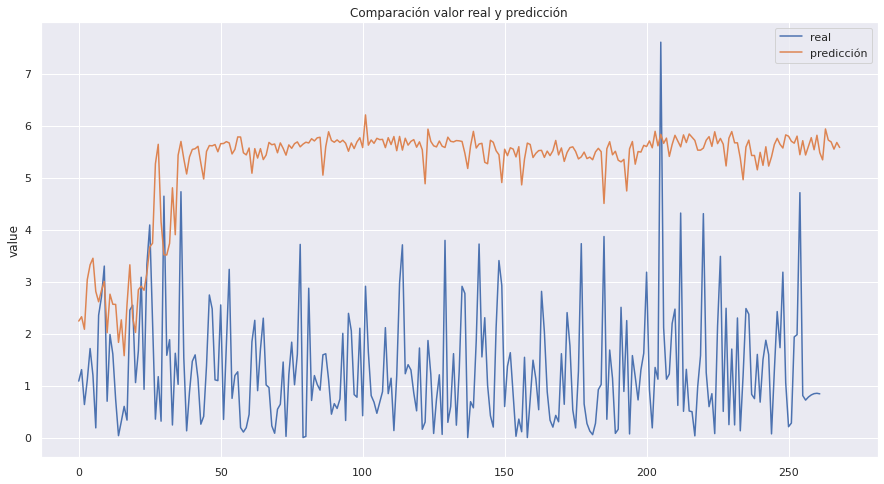

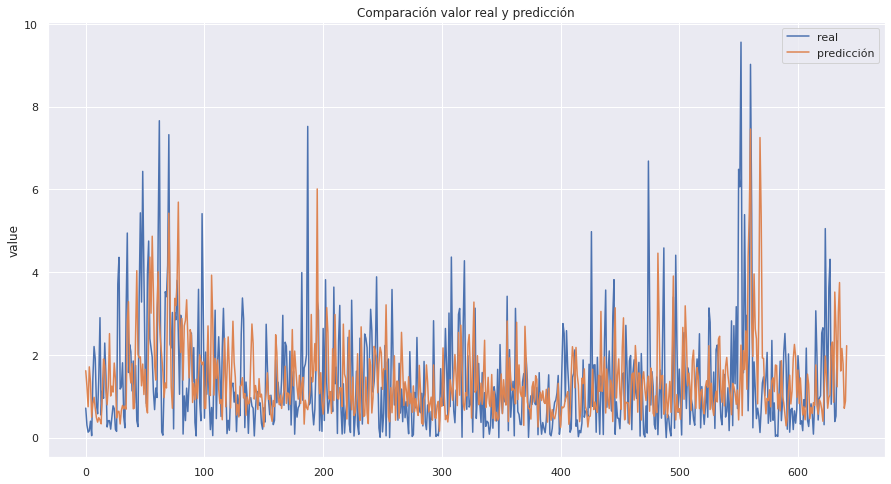

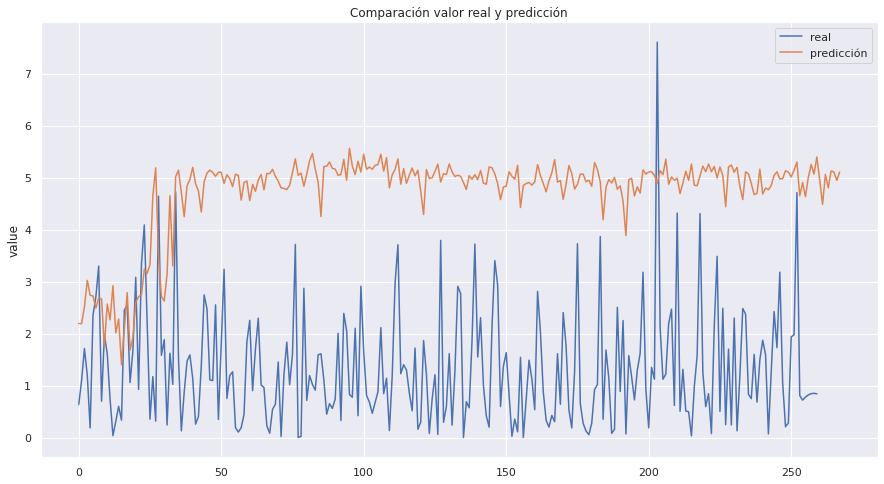

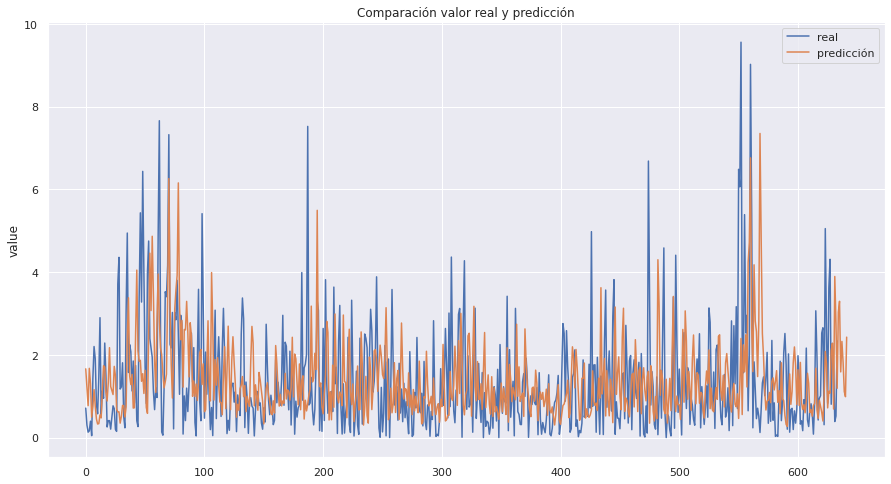

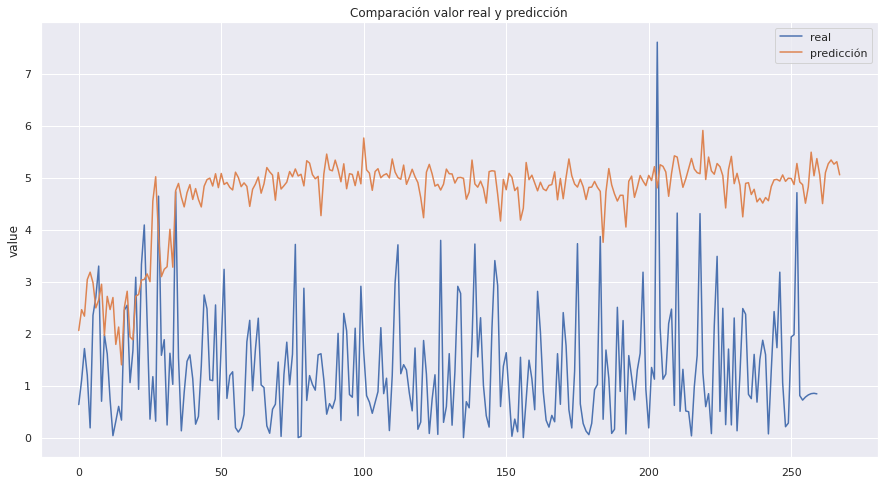

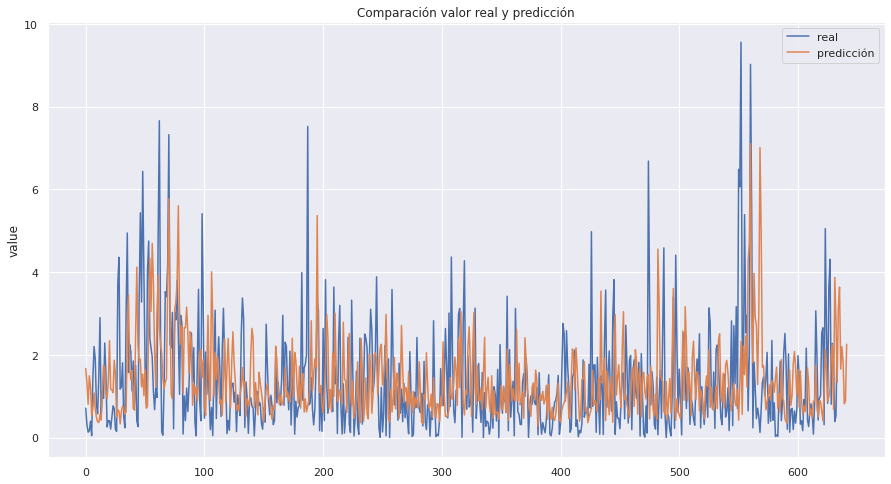

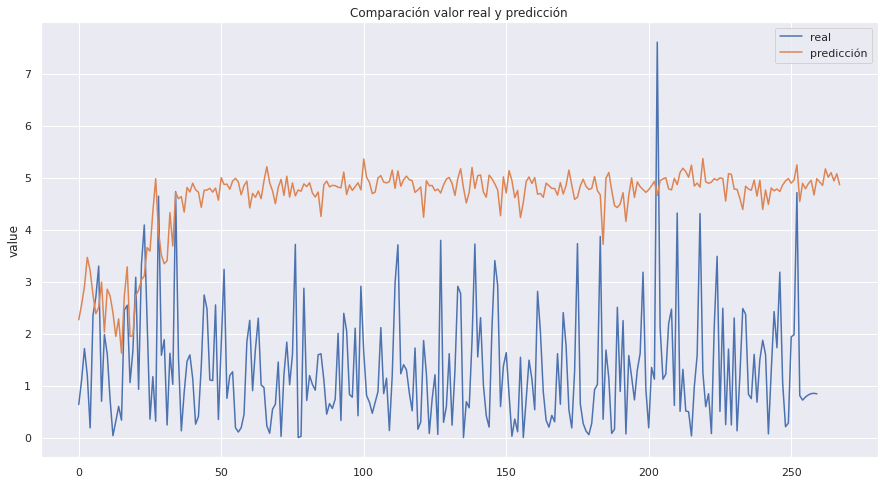

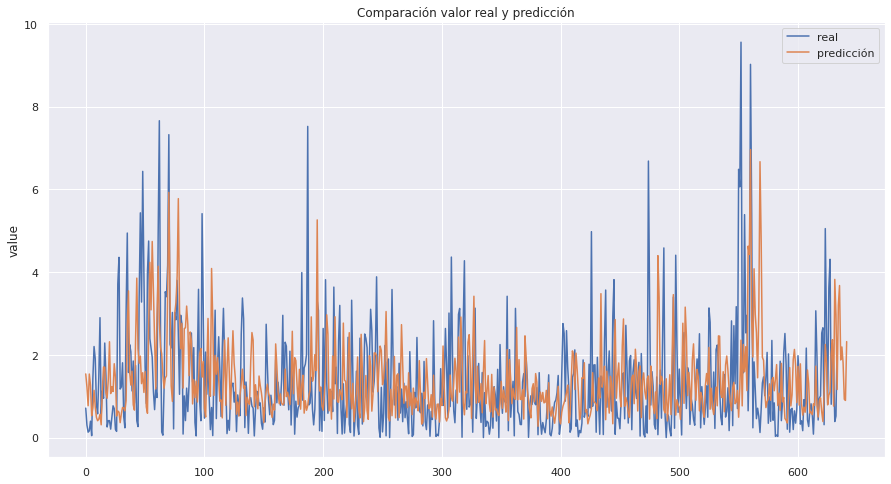

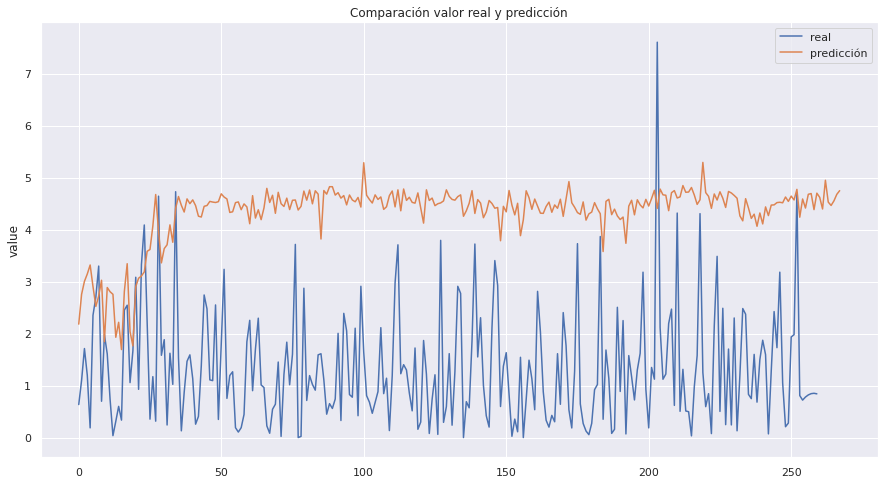

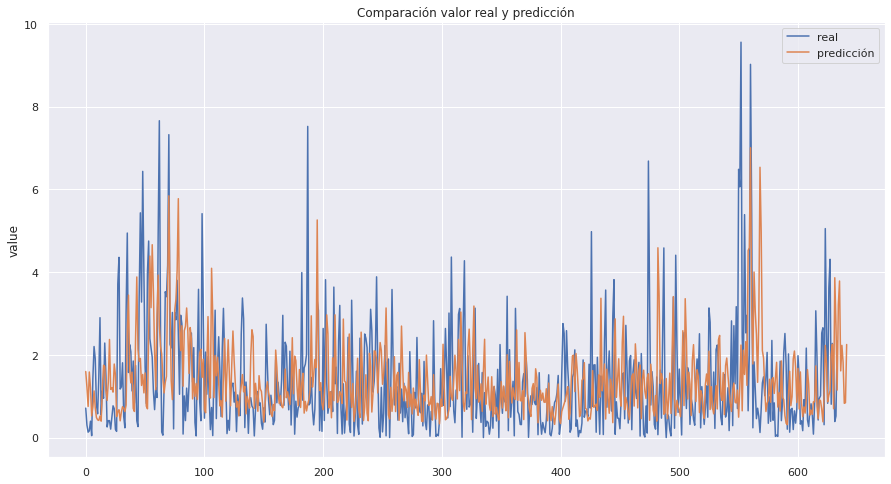

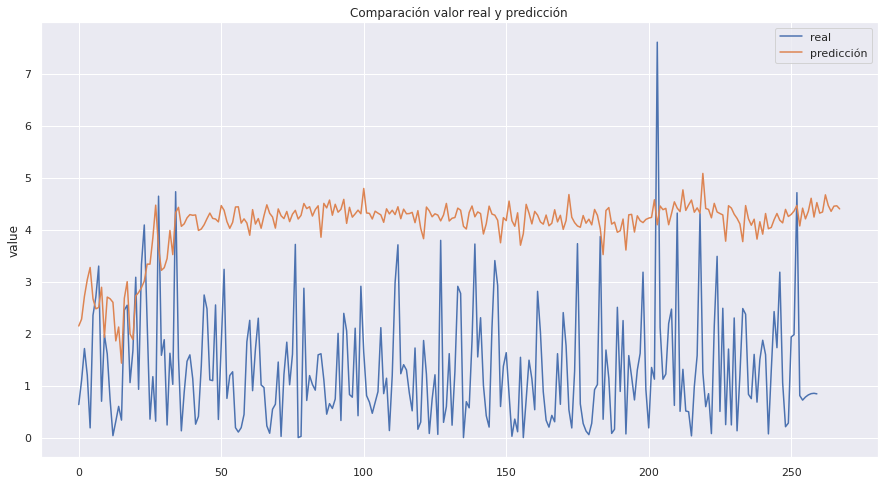

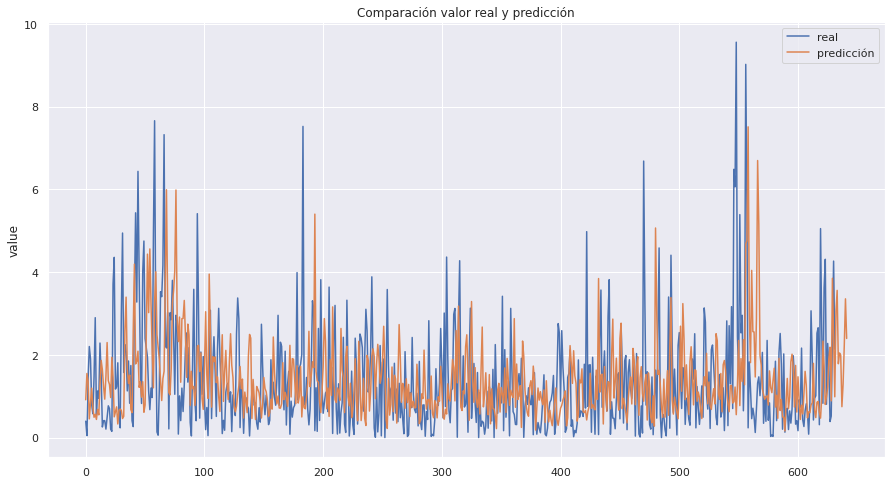

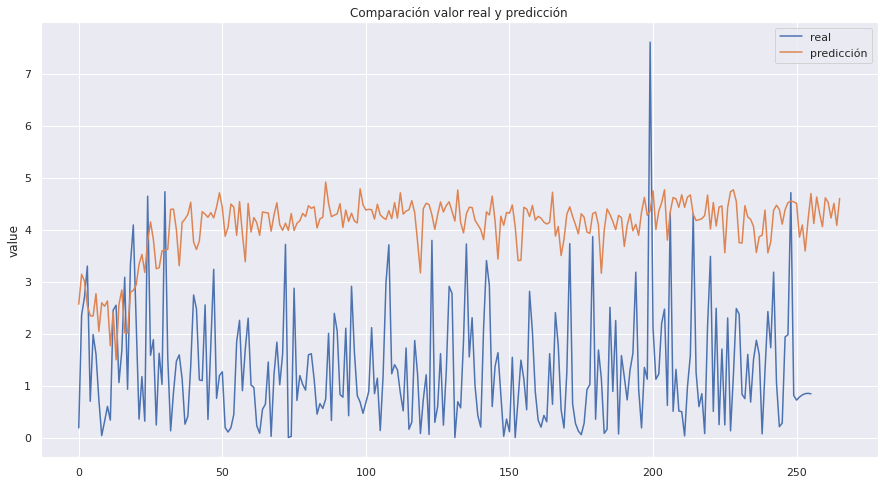

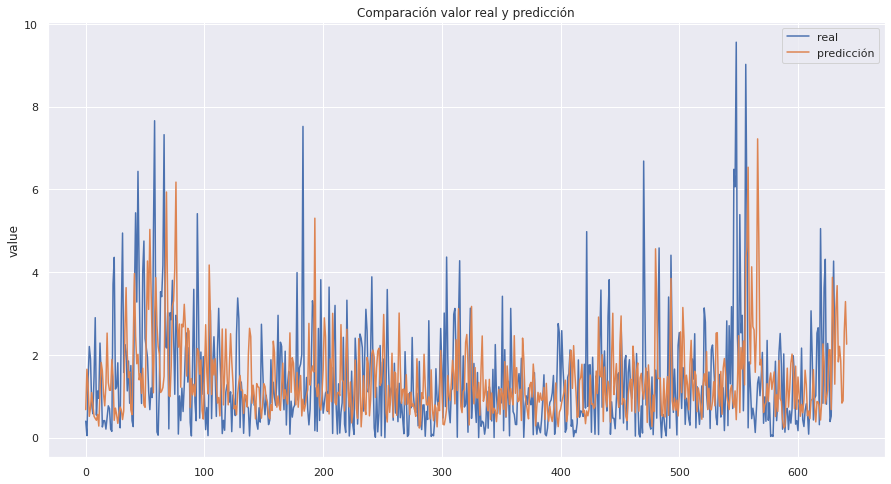

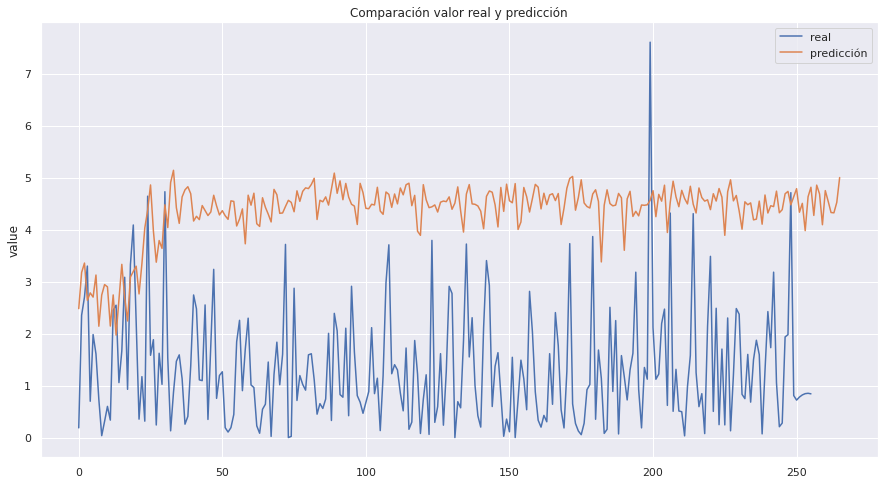

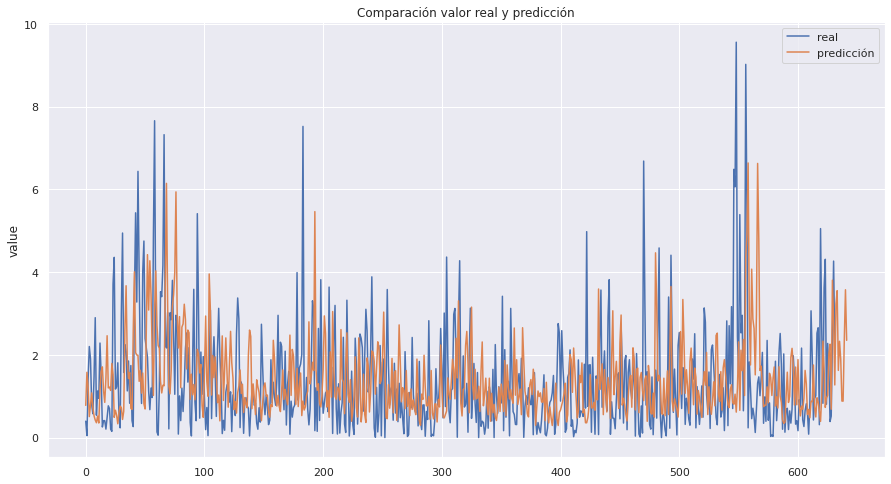

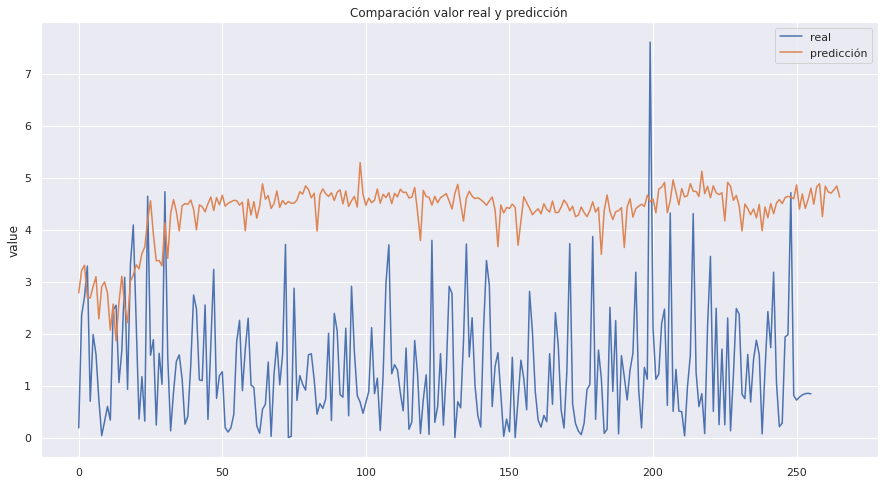

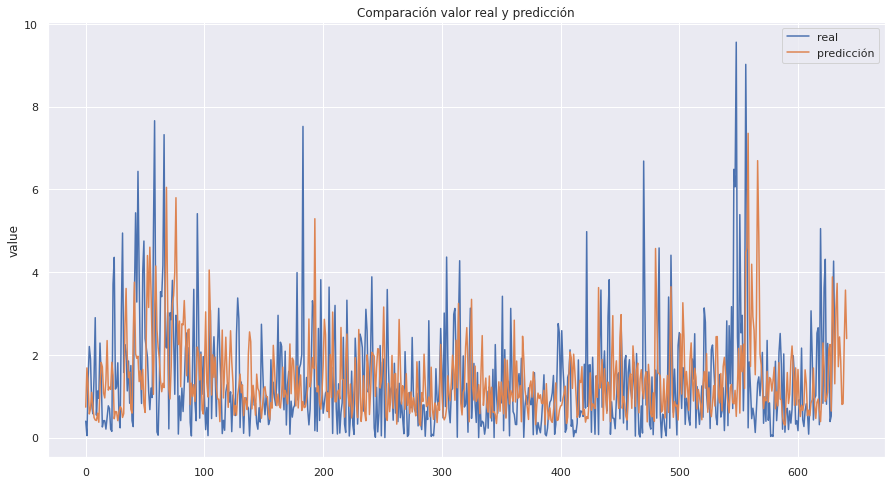

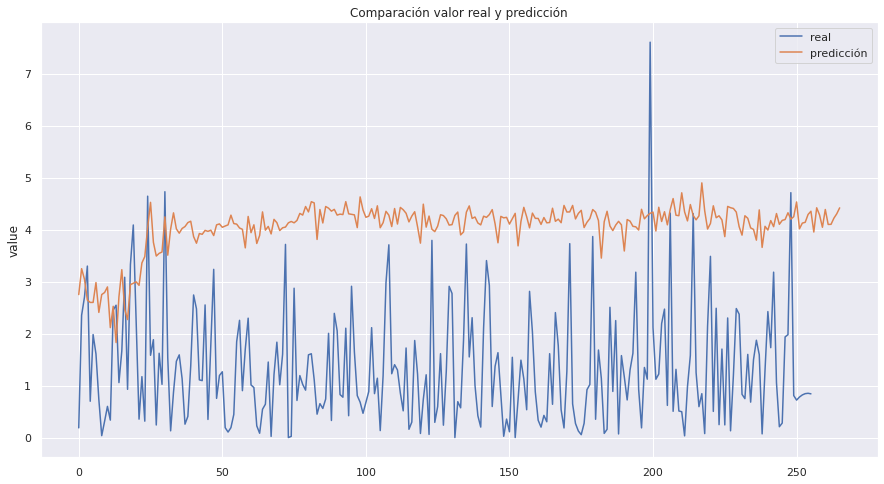

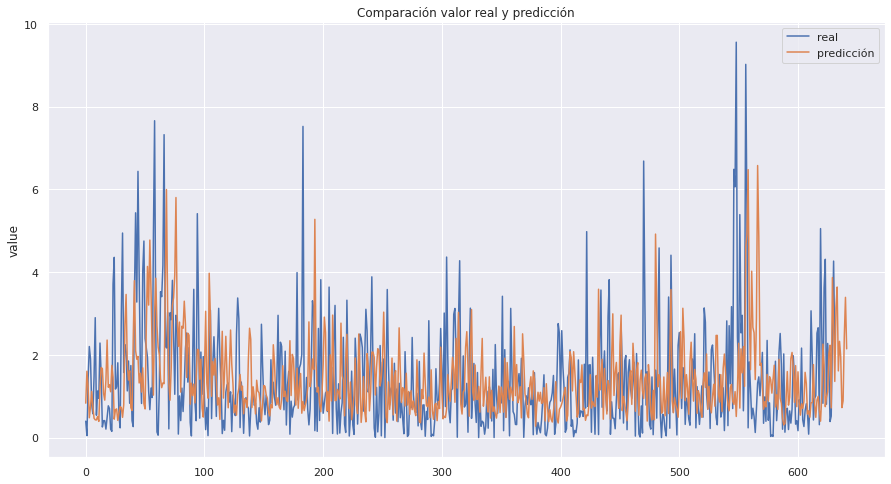

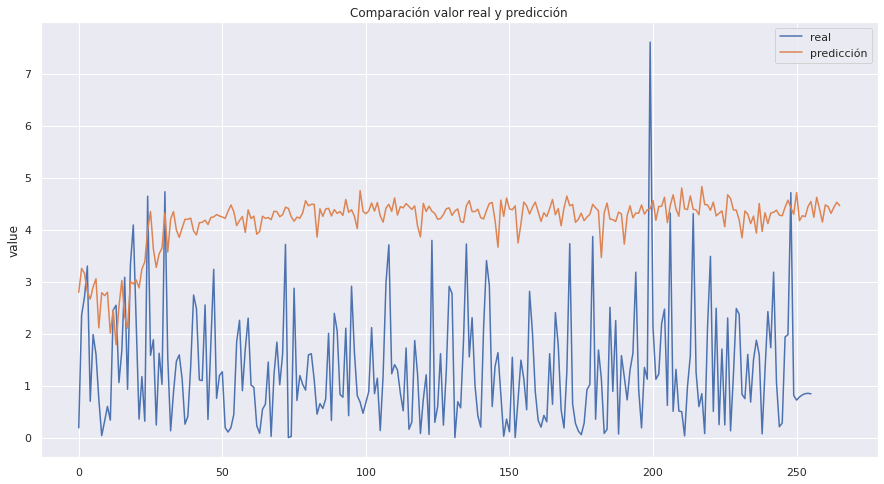

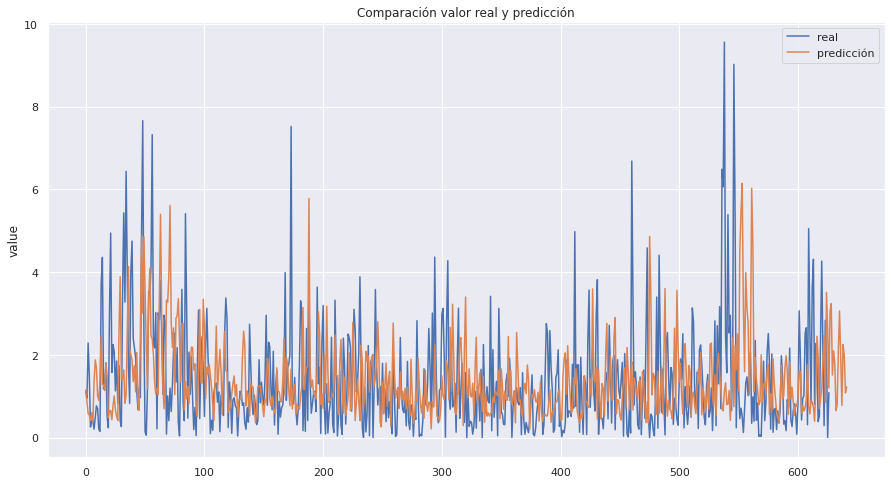

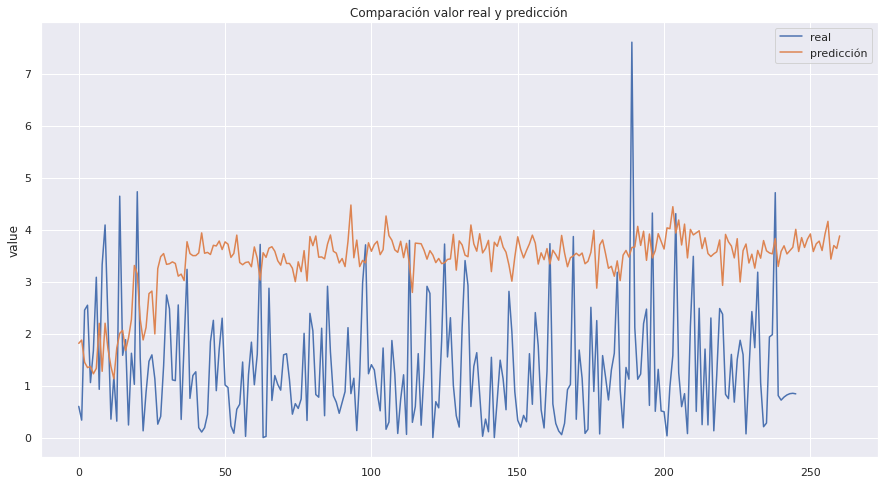

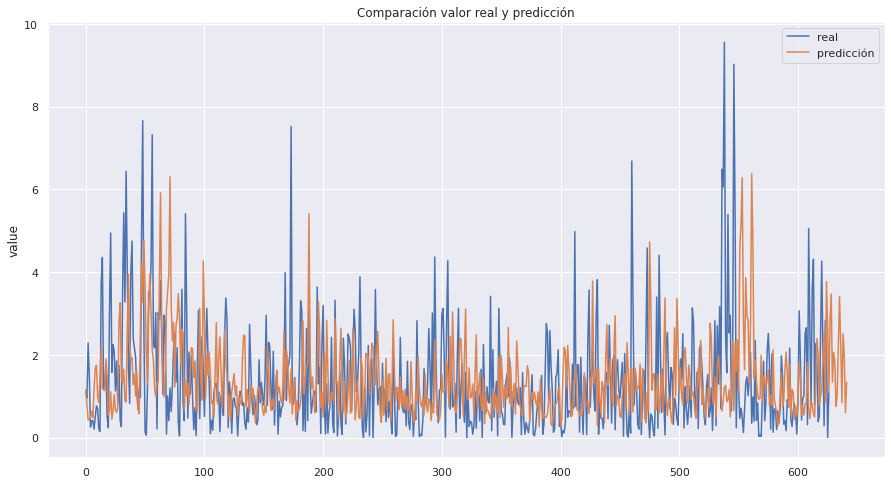

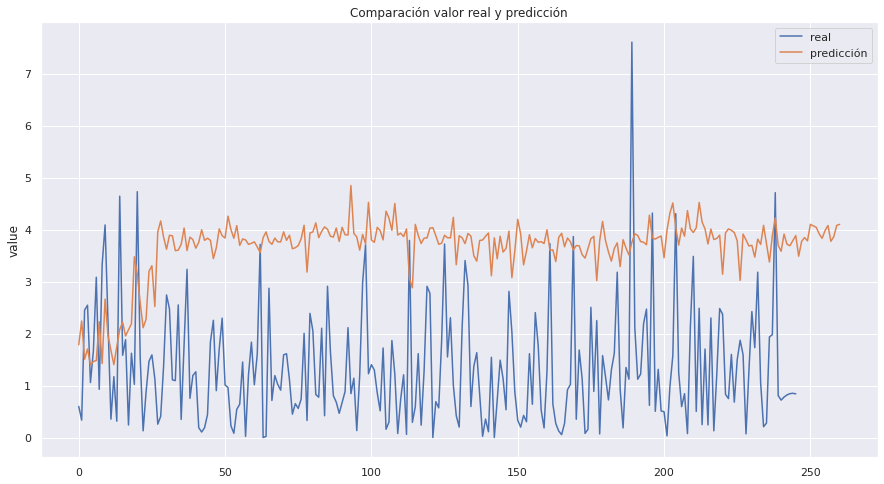

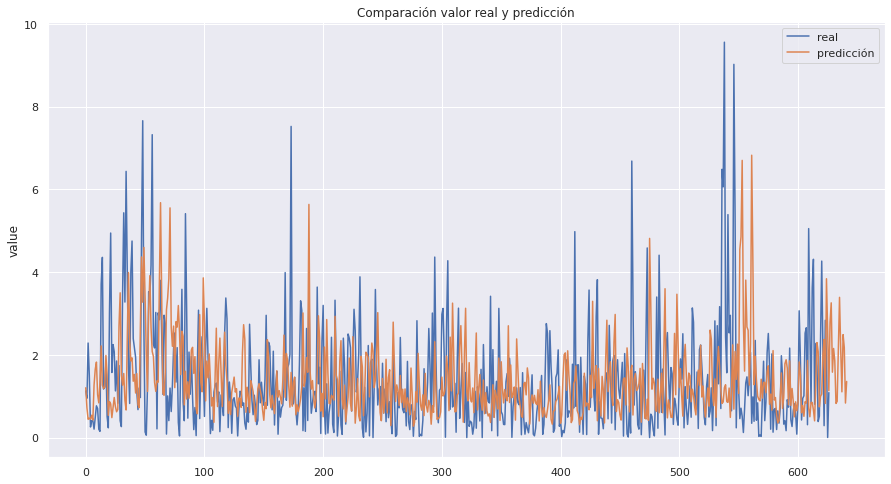

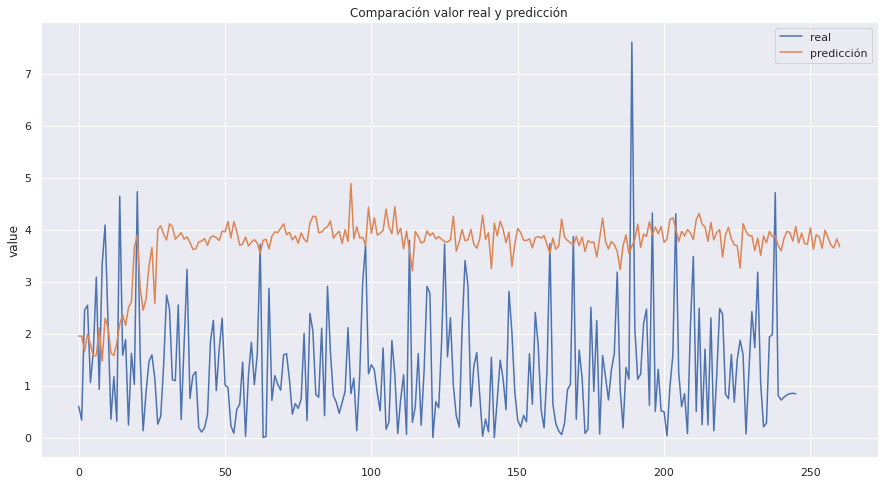

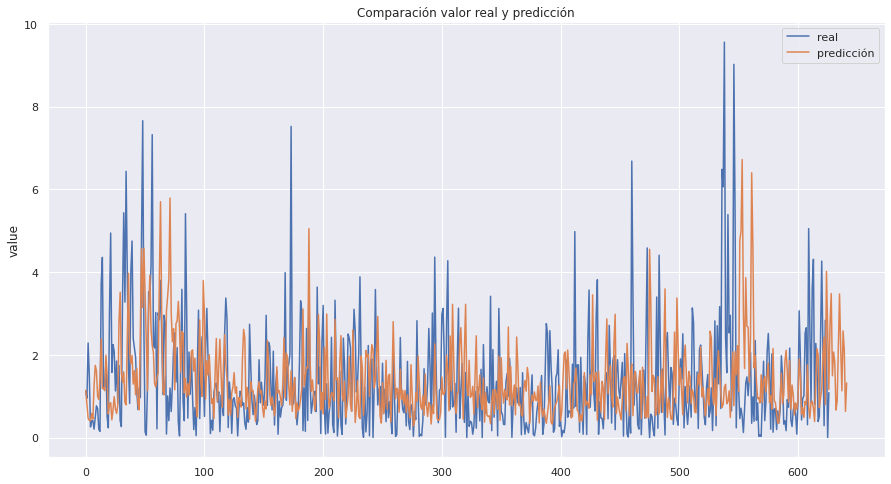

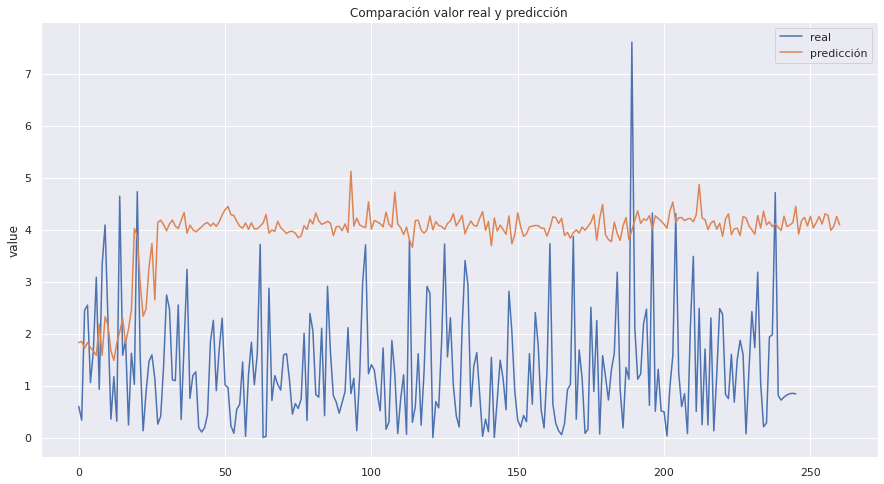

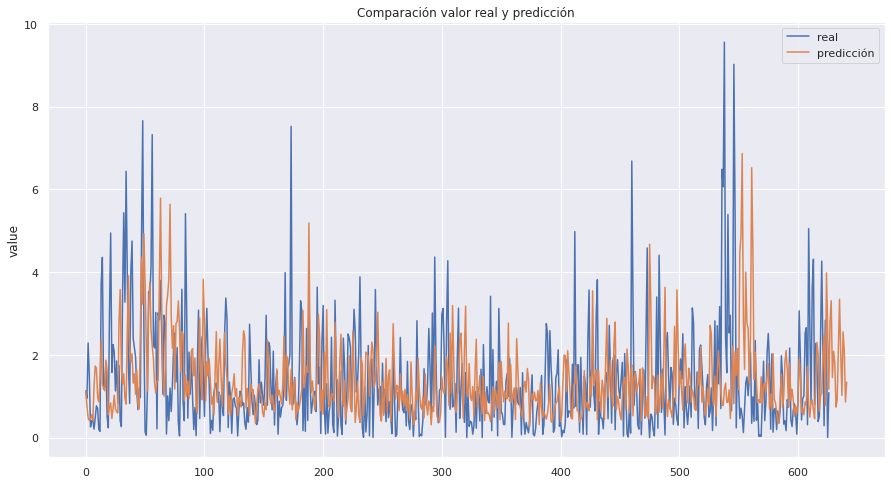

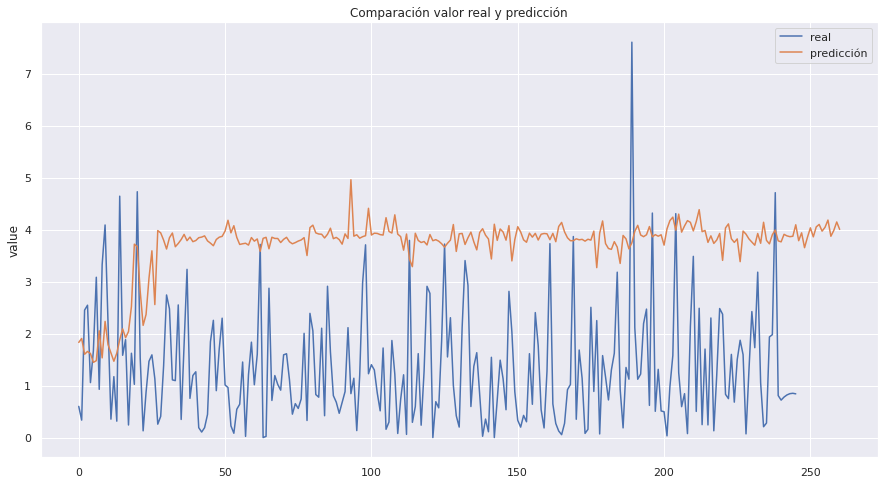

In [11]:
lags=[3,5,7,8,10,15]
n_estimators=[50,100,200,300,500]
results_models={i:{} for i in lags}
for lg in lags:
    for est in n_estimators:
        results_models[lg][est]=Model(df_data.copy(),df_label.copy(),lg,est)